In [5]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Graph Overview - CA Prep

- In this notebook, I will perform various check in order to make sure my data is ready for CA implementation

- This includes:
    - Data distribution checks
    - Node and edge analysis; various graph metrics and visualisations. Are there any clusters etc?
    - Assumptions of CA?
    - Connectedness of my graph

I'm starting with an edge list. Each row represents an edge (a follower-brand relationship) in the graph. From the edge list, I should create a directed graph. 

In [3]:
#Load the edge list
#Load marker followers
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

edgelist = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

#It might be a good idea to use the most informative subset of my data, like in the original study (He and Tsvetkova.) They selected users who follow at least one brand across all their brand domains. I'll do the same.

In [9]:
#Load in the excel file
# Full path to the Excel file
file_path = '/home/livtollanes/SocialMarkers/MarkersFrenchTwitter.xlsx'

# Load the Excel file
cats = pd.read_excel(file_path)

# Display the first 5 rows
print(cats.head())

     marque twitter_name   type Unnamed: 3
0      Nike         Nike  sport        NaN
1    Adidas     adidasFR  sport        NaN
2   Lacoste      Lacoste  sport        NaN
3  Converse     Converse  sport        NaN
4   Moncler      Moncler  sport        NaN


In [10]:
# Print the unique values in the 'type' column
print(cats['type'].unique())

['sport' 'grande distribution' 'media' 'chain restaurants'
 'luxe vetements et malls' 'magazine' 'clubs de football' 'party'
 'universities' 'ecoles de commerce' 'Lycées professionels' 'commerce']


In [14]:
# Load the followers bios and rename ID columns
full_path = '/home/livtollanes/SocialMarkers/markers_bios_2023-05-19.csv'

req_cols = ['twitter_name', 'id']

dtypes = {
    'twitter_name': 'object',
    'id': 'object'
}

marker_ids = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes)


#rename the twittwer id column to follower id 
marker_ids.rename(columns={'id':'marker_id'}, inplace=True)


#map marker_ids onto cats from marker:ids
cat_id = cats.merge(marker_ids, on='twitter_name', how='left')

In [22]:
cat_id.head()

,marque,twitter_name,type,Unnamed: 3,marker_id
0,Nike,Nike,sport,NaN,415859364
1,Adidas,adidasFR,sport,NaN,25487201
2,Lacoste,Lacoste,sport,NaN,18481641
3,Converse,Converse,sport,NaN,183398746
4,Moncler,Moncler,sport,NaN,187897893


In [24]:
#Make an inofrmative edgelist

# Merge edgelist with cats on 'marker_id'
merged = edgelist.merge(cat_id, on='marker_id')

In [25]:
merged.head()   

,marker_id,follower_id,marque,twitter_name,type,Unnamed: 3
0,415859364,1301293067945807877,Nike,Nike,sport,NaN
1,415859364,1233001848006729729,Nike,Nike,sport,NaN
2,415859364,2768568386,Nike,Nike,sport,NaN
3,415859364,1152271993225433089,Nike,Nike,sport,NaN
4,415859364,947287974882021377,Nike,Nike,sport,NaN


In [41]:

# Count the number of unique 'marque's for each 'follower_id' and 'type'

# Get the total number of unique types
total_unique_types = merged['type'].nunique()

# Group by 'follower_id' and count the number of unique 'type's for each 'follower_id'
unique_types_per_user = merged.groupby('follower_id')['type'].nunique()

# Find 'follower_id's that follow at least 6 unique types
final_follower_ids = unique_types_per_user[unique_types_per_user >= 5]

# Filter edgelist to keep only the 'follower_id's that follow at least 6 unique types
final_edgelist = edgelist[edgelist['follower_id'].isin(final_follower_ids.index)]

In [43]:
#number of unique follower_id in final edgelist - users that follow at least 5 unique types
final_edgelist['follower_id'].nunique() #135 743 users
final_edgelist['marker_id'].nunique() # 235 markers represented

235

In [46]:
final_edgelist.head()

,marker_id,follower_id
5,415859364,1647558995886964739
9,415859364,114730871
11,415859364,4895854473
14,415859364,1306623527190237185
20,415859364,1382284704


In [28]:
#how many unique types are there in merged?
merged['type'].unique()

array(['sport', 'grande distribution', 'media', 'chain restaurants',
       'luxe vetements et malls', 'magazine', 'clubs de football',
       'party', 'universities', 'ecoles de commerce',
       'Lycées professionels', 'commerce'], dtype=object)

Make dge list into a graph.
An edge list is a simple, tabular representation of a graph, while a graph is amore complex data structure that allows for more advance operations, such s finding paths and calculating graph metrics.

### Graph metrics

In [47]:

# Create a new bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(final_edgelist['follower_id'].unique(), bipartite=0)
B.add_nodes_from(final_edgelist['marker_id'].unique(), bipartite=1)

# Add edges
B.add_edges_from(list(zip(final_edgelist['follower_id'], final_edgelist['marker_id'])))

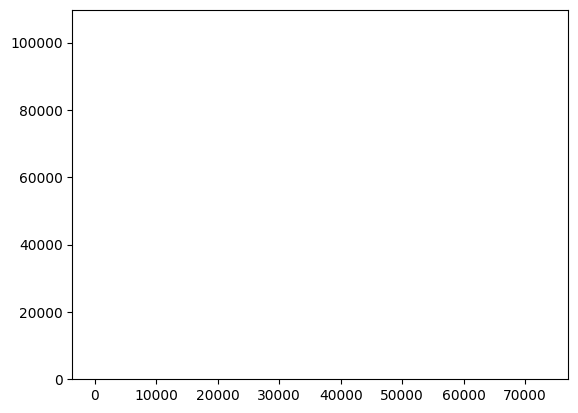

In [48]:
# Separate the nodes by type
follower_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
marker_nodes = set(B) - follower_nodes

# Calculate the degree of each node
follower_degrees = [B.degree(n) for n in follower_nodes]
marker_degrees = [B.degree(n) for n in marker_nodes]

# Plot the degree distributions
plt.hist(follower_degrees, alpha=0.5)
plt.hist(marker_degrees, alpha=0.5)
plt.show()

In [49]:
# Calculate connected components
connected_components = list(nx.connected_components(B))

# Print the number of connected components
print("Number of connected components:", len(connected_components))

# Print the size of the largest connected component
print("Size of largest connected component:", max(len(c) for c in connected_components))

Number of connected components: 1
Size of largest connected component: 135958


In [50]:
# Calculate degree centrality for followers and markers
follower_degree_centrality = nx.degree_centrality(B.subgraph(follower_nodes))
marker_degree_centrality = nx.degree_centrality(B.subgraph(marker_nodes))

In [53]:
# # Create projections
# follower_projection = nx.projected_graph(B, follower_nodes)
# marker_projection = nx.projected_graph(B, marker_nodes)



[2182,
 1808,
 3630,
 29491,
 26,
 25218,
 22,
 12998,
 1605,
 712,
 3042,
 3257,
 16,
 1376,
 191,
 5132,
 13823,
 4895,
 190,
 13911,
 711,
 15170,
 65716,
 255,
 2117,
 24395,
 418,
 10327,
 1480,
 648,
 6811,
 7522,
 271,
 122,
 15961,
 26171,
 64,
 25354,
 11267,
 6709,
 13091,
 2537,
 2366,
 24,
 18833,
 12397,
 3241,
 18074,
 14377,
 1796,
 1825,
 593,
 12795,
 592,
 9931,
 26,
 32779,
 1421,
 12,
 12957,
 3240,
 1560,
 8179,
 42089,
 21209,
 20739,
 782,
 4242,
 33,
 6876,
 13755,
 2127,
 5255,
 284,
 15962,
 9402,
 44,
 1916,
 28558,
 8685,
 9020,
 1956,
 6225,
 22697,
 2814,
 15622,
 5870,
 9706,
 1366,
 7208,
 1973,
 6458,
 16718,
 35591,
 780,
 2058,
 103,
 34736,
 229,
 997,
 100,
 11863,
 3465,
 1020,
 7120,
 1218,
 3648,
 1286,
 210,
 1720,
 53513,
 4,
 3145,
 5494,
 1576,
 3027,
 9382,
 182,
 52302,
 2593,
 7065,
 10809,
 2355,
 30369,
 2770,
 448,
 19732,
 4184,
 37710,
 1089,
 1649,
 700,
 8654,
 14461,
 7010,
 1081,
 4543,
 6221,
 343,
 260,
 510,
 27079,
 12635,
 87

### Connectivity in Graph Theory
Connectivity is one of the basics in graph theory. Connectivity is related to the question of the minimal number of elements (nodes or edges) needed to separate the remaining nodes into two or more separated subgraphs. The connectedness of a graph is an important measure of ts recilience as a network. 